In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
import cv2
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout,BatchNormalization, LeakyReLU
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter, sobel
#from skimage import exposure
from keras.optimizers import SGD,Adam
#from scipy import ndimage
import pandas as pd
from tensorflow.keras.models import Sequential
from skimage import filters
from sklearn.model_selection import train_test_split

In [3]:

path='Desktop\\data\\'
image_data_df = pd.read_csv(path+"Data.csv", header=None) 
print(image_data_df.head(5))
labels_df = pd.read_csv(path+"classLabel.csv", header=None)
label_names_df = pd.read_csv(path+"nameOfLabel.csv")
print(label_names_df.head(5))
image_data_df
labels_df

   0     1     2     3     4     5     6     7     8     9     ...  3062  \
0    59    43    50    68    98   119   139   145   149   149  ...    59   
1   154   126   105   102   125   155   172   180   142   111  ...    22   
2   255   253   253   253   253   253   253   253   253   253  ...    78   
3    28    37    38    42    44    40    40    24    32    43  ...    53   
4   170   168   177   183   181   177   181   184   189   189  ...    92   

   3063  3064  3065  3066  3067  3068  3069  3070  3071  
0    58    65    59    46    57   104   140    84    72  
1    42    67   101   122   133   136   139   142   144  
2    83    80    69    66    72    79    83    83    84  
3    39    59    42    44    48    38    28    37    46  
4    88    85    82    83    79    78    82    78    80  

[5 rows x 3072 columns]
           Name  class Label 
0    'airplane'             0
1  'automobile'             1
2        'bird'             2
3         'cat'             3
4        'deer'     

,0
0,6
1,9
2,9
3,4
4,1
...,...
9995,3
9996,9
9997,1
9998,1


In [4]:
num_duplicates = image_data_df.duplicated().sum()

print("Number of Duplicate Rows:", num_duplicates)

Number of Duplicate Rows: 0


In [5]:
# Define the coefficients for the RGB to Grayscale conversion
coefficients = np.array([0.2989, 0.5870, 0.1140])

grayscale_images = []

for i in range(len(image_data_df)):
    row = np.array(image_data_df.iloc[i].values)
    image_array = row.reshape(3, 32, 32).astype(np.uint8)
    image_array = np.transpose(image_array, (1, 2, 0))
    # Apply dot product for the grayscale conversion
    grayscale_image_array = np.dot(image_array, coefficients)

    # Append the grayscale image to the list
    grayscale_images.append(grayscale_image_array)
    
# Optional: Convert the list to a NumPy array if needed
grayscale_images = np.array(grayscale_images)

In [6]:
#this is used for applying different filters and see which gets best accuracy

def preprocess_images(image_paths):
    processed_images = []

    for img in image_paths:
        prewitt_x = filters.prewitt_h(img)  # Horizontal edges
        prewitt_y =filters.prewitt_v(img) # Vertical edges
        #gradient_magnitude = np.hypot(prewitt_x, prewitt_y)
        # Recompute the gradient magnitude using the Sobel filter
        gaussian_blurred = filters.gaussian(img, sigma=1)
        laplacian = filters.laplace(gaussian_blurred)
        sobel_x = filters.sobel_h(gaussian_blurred)  # Horizontal gradient
        sobel_y = filters.sobel_v(gaussian_blurred)  # Vertical gradient
       # gradient_magnitude = np.hypot(sobel_x, sobel_y)
        processed_images.append(laplacian)

    return processed_images

processed_dataset = preprocess_images(grayscale_images)
processed_dataset = np.array(processed_dataset)

(<matplotlib.image.AxesImage at 0x20dab3714c8>,
 (-0.5, 31.5, 31.5, -0.5),
 Text(0.5, 1.0, 'Filtered Image Filter'))

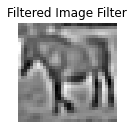

In [7]:

# Display the sharpened image
plt.subplot(2, 2, 4)
plt.imshow(processed_dataset[7], cmap='gray'), plt.axis('off'), plt.title('Filtered Image Filter')

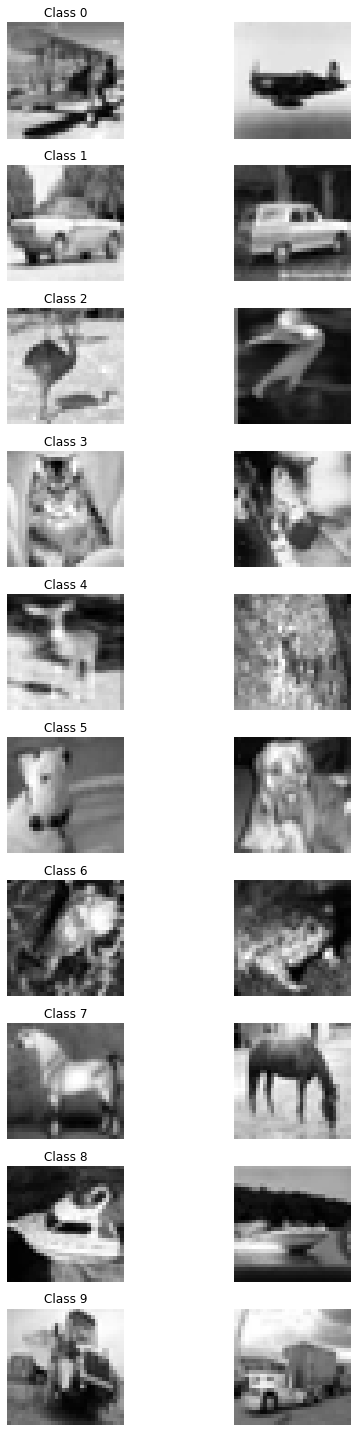

[[-12.72667025 -26.58361778 -33.33178165 ...  27.42585384  22.63953358
   21.76822181]
 [  2.07346031  -3.31731746   6.67293826 ...  25.80529787  27.98771784
   32.66530658]
 [ 20.48143391   5.37555595   8.04935042 ...  -2.74246415   4.13270788
   13.11814049]
 ...
 [  3.56467696   1.86783408   2.45467894 ...   7.01872831   6.7383733
    6.14379356]
 [ -0.0773437    2.18446765   5.22320905 ...   5.80451727   5.17213691
    4.23756723]
 [ -1.39403455   1.50453577   5.49964158 ...   5.78293408   5.5711491
    5.35762681]]


In [119]:
# total number of class
num_classes = len(np.unique(labels_df))
# Number of images per class
images_per_class= 2
# dimensions of images to be displayed
fig, axs = plt.subplots(num_classes,images_per_class, figsize=(8, num_classes * 2))

for class_idx in range(num_classes):
    # store all the image indices of current class in indices
    indices = np.where(labels_df == class_idx)[0]
    #pick selected number of images 
    selected_indices = np.random.choice(indices, images_per_class, replace=False)
    for plot_idx, image_idx in enumerate(selected_indices):
        ax = axs[class_idx, plot_idx]
        ax.imshow(grayscale_images[image_idx], cmap='gray' if grayscale_images[image_idx].ndim == 2 else None)
        ax.axis('off')
        if plot_idx == 0:
            ax.set_title(f'Class {class_idx}')
plt.tight_layout()
plt.show()
print(processed_dataset[9])

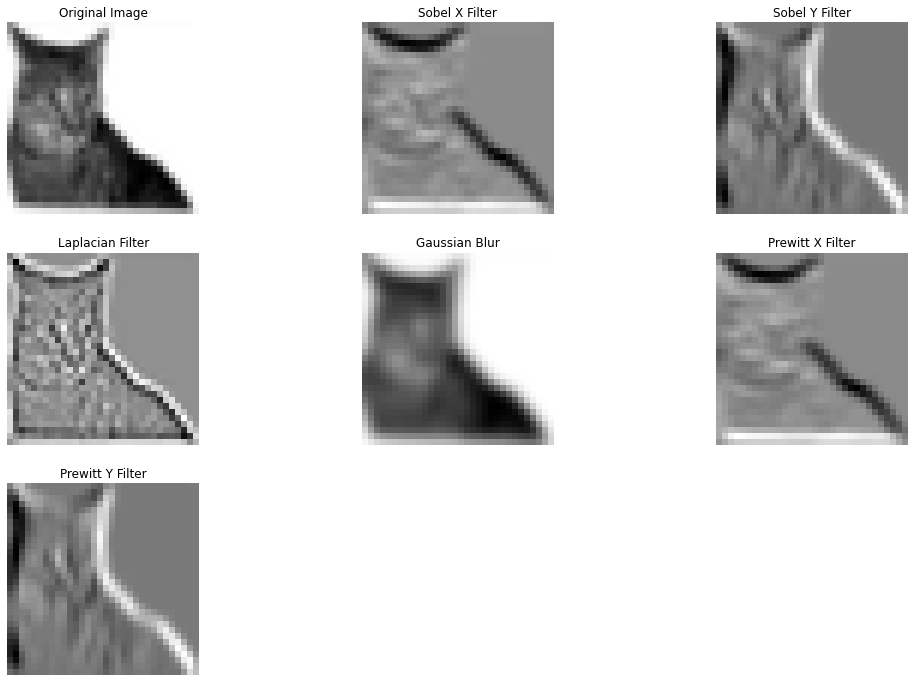

In [9]:

# Load the image in grayscale
image = grayscale_images[998]

# Apply the filters
gaussian_blurred = filters.gaussian(image, sigma=1)
prewitt_x = filters.prewitt_h(image)  # Horizontal edges
prewitt_y =filters.prewitt_v(image) # Vertical edges
#gradient_magnitude = np.hypot(prewitt_x, prewitt_y)
# Recompute the gradient magnitude using the Sobel filter
laplacian = filters.laplace(image)
sobel_x = filters.sobel_h(image)  # Horizontal gradient
sobel_y = filters.sobel_v(image)  # Vertical gradient
#gradient_magnitude = np.hypot(sobel_x, sobel_y)

# Display the images
plt.figure(figsize=(18, 12))
plt.subplot(3, 3, 1)
plt.imshow(image, cmap='gray'), plt.axis('off'), plt.title('Original Image')
plt.subplot(3, 3, 2)
plt.imshow(sobel_x, cmap='gray'), plt.axis('off'), plt.title('Sobel X Filter')
plt.subplot(3, 3, 3)
plt.imshow(sobel_y, cmap='gray'), plt.axis('off'), plt.title('Sobel Y Filter')
plt.subplot(3, 3, 4)
plt.imshow(laplacian, cmap='gray'), plt.axis('off'), plt.title('Laplacian Filter')
plt.subplot(3, 3, 5)
plt.imshow(gaussian_blurred, cmap='gray'), plt.axis('off'), plt.title('Gaussian Blur')
plt.subplot(3, 3, 6)
plt.imshow(prewitt_x, cmap='gray'), plt.axis('off'), plt.title('Prewitt X Filter')
plt.subplot(3, 3, 7)
plt.imshow(prewitt_y, cmap='gray'), plt.axis('off'), plt.title('Prewitt Y Filter')
plt.show()

In [10]:

#processed_dataset= processed_dataset/255.0
# Split the data - 70% training, 30% testing

# Split the dataset into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(grayscale_images, labels_df, test_size=0.3, random_state=42)

# Checking the shape of the datasets
len(X_train), len(X_test), len(y_train), len(y_test)

(7000, 3000, 7000, 3000)

In [70]:
#simple model

model = Sequential()

# Adding the first convolutional layer with Leaky ReLU and Dropout
# Build CNN Model
model = Sequential([
    Conv2D(32, (3, 3), input_shape=(32,32,1)),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3)),
    LeakyReLU(alpha=0.01),
    Conv2D(64, (3, 3)),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64),
    LeakyReLU(alpha=0.01),
    Dense(10, activation='softmax')  # Assuming 10 classes
])

In [71]:
model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_85 (Conv2D)          (None, 30, 30, 32)        320       
                                                                 
 batch_normalization_62 (Bat  (None, 30, 30, 32)       128       
 chNormalization)                                                
                                                                 
 leaky_re_lu_145 (LeakyReLU)  (None, 30, 30, 32)       0         
                                                                 
 max_pooling2d_67 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_86 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 leaky_re_lu_146 (LeakyReLU)  (None, 13, 13, 64)     

In [72]:
optimizer = Adam(learning_rate=0.001)

#opt = SGD(learning_rate=0.001, momentum=0.9)

#model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']) "experimenting for better results : we can try both"
model.compile(optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train,y_train, epochs=17)#epochs "17, 18 and 20 are giving best results results mey change on intitial weights intializations"

Epoch 1/17
219/219 [==============================] - 8s 34ms/step - loss: 1.9233 - accuracy: 0.3217
Epoch 2/17
219/219 [==============================] - 7s 32ms/step - loss: 1.5379 - accuracy: 0.4597
Epoch 3/17
219/219 [==============================] - 7s 33ms/step - loss: 1.3354 - accuracy: 0.5320
Epoch 4/17
219/219 [==============================] - 7s 33ms/step - loss: 1.1820 - accuracy: 0.5881
Epoch 5/17
219/219 [==============================] - 8s 36ms/step - loss: 1.0788 - accuracy: 0.6216
Epoch 6/17
219/219 [==============================] - 8s 38ms/step - loss: 0.9730 - accuracy: 0.6614
Epoch 7/17
219/219 [==============================] - 9s 39ms/step - loss: 0.8838 - accuracy: 0.6956
Epoch 8/17
219/219 [==============================] - 9s 39ms/step - loss: 0.7604 - accuracy: 0.7417
Epoch 9/17
219/219 [==============================] - 9s 39ms/step - loss: 0.6632 - accuracy: 0.7717
Epoch 10/17
219/219 [==============================] - 8s 38ms/step - loss: 0.5697 - accura

In [73]:
#main model
loss, accuracy = model.evaluate(X_test, y_test)

""
print(f"Test accuracy: {accuracy}")


94/94 [==============================] - 1s 10ms/step - loss: 1.8103 - accuracy: 0.5677
Test accuracy: 0.5676666498184204


In [74]:
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, predicted_classes)
print(f"Model Accuracy on Test Set: {accuracy * 100:.2f}%")


94/94 [==============================] - 1s 8ms/step
Model Accuracy on Test Set: 56.77%


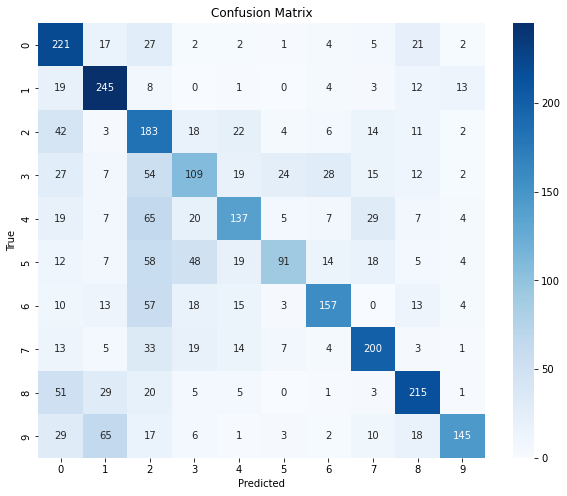

In [75]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_test, predicted_classes)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()